In [11]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

In [12]:
# Open NCEP GFS dataset; change name accordingly to yours
ds = xr.open_dataset('081416_0600H.f00_Analysis.nc4')
ds

<xarray.Dataset>
Dimensions:                                                          (sigma: 1,
                                                                      potential_vorticity_surface: 2,
                                                                      pressure_difference_layer2: 2,
                                                                      bounds_dim: 2,
                                                                      latitude: 29,
                                                                      height_above_ground1: 3,
                                                                      ...
                                                                      height_above_ground_layer: 1,
                                                                      isobaric3: 31,
                                                                      isobaric1: 21,
                                                                      time: 1,
                                                                      height_above_ground_layer1: 1,
                                                                      longitude: 33)
Coordinates: (12/13)
  * sigma                                                            (sigma) float64 ...
  * potential_vorticity_surface                                      (potential_vorticity_surface) float64 ...
  * pressure_difference_layer2                                       (pressure_difference_layer2) float64 ...
  * latitude                                                         (latitude) float32 ...
  * height_above_ground1                                             (height_above_ground1) float64 ...
  * height_above_ground3                                             (height_above_ground3) float64 ...
    ...                                                               ...
    reftime                                                          datetime64[ns] ...
  * isobaric3                                                        (isobaric3) float64 ...
  * isobaric1                                                        (isobaric1) float64 ...
  * time                                                             (time) datetime64[ns] ...
  * height_above_ground_layer1                                       (height_above_ground_layer1) float64 ...
  * longitude                                                        (longitude) float32 ...
Dimensions without coordinates: bounds_dim
Data variables: (12/29)
    pressure_difference_layer2_bounds                                (pressure_difference_layer2, bounds_dim) float64 ...
    height_above_ground_layer_bounds                                 (height_above_ground_layer, bounds_dim) float64 ...
    height_above_ground_layer1_bounds                                (height_above_ground_layer1, bounds_dim) float64 ...
    U-Component_Storm_Motion_height_above_ground_layer               (time, height_above_ground_layer1, latitude, longitude) float32 ...
    Vertical_velocity_pressure_isobaric                              (time, isobaric1, latitude, longitude) float32 ...
    Convective_inhibition_surface                                    (time, latitude, longitude) float32 ...
    ...                                                               ...
    u-component_of_wind_isobaric                                     (time, isobaric3, latitude, longitude) float32 ...
    Dewpoint_temperature_height_above_ground                         (time, height_above_ground3, latitude, longitude) float32 ...
    Storm_relative_helicity_height_above_ground_layer                (time, height_above_ground_layer, latitude, longitude) float32 ...
    V-Component_Storm_Motion_height_above_ground_layer               (time, height_above_ground_layer1, latitude, longitude) float32 ...
    Vertical_velocity_pressure_sigma                                 (time, sigma, latitude, longitude) float32 ...
    LatLon_721X1440-0p13S-180p00E     

In [13]:
# Combining with NCEP, open ERA5 Single Levels; change name accordingly to yours. 
ds1 = xr.open_dataset('EU_MESOSCALE_SL.nc')
ds1

<xarray.Dataset>
Dimensions:    (longitude: 33, latitude: 29, time: 24)
Coordinates:
  * longitude  (longitude) float32 117.0 117.2 117.5 117.8 ... 124.5 124.8 125.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 13.5 13.25 13.0
  * time       (time) datetime64[ns] 2016-08-14 ... 2016-08-14T23:00:00
Data variables:
    v100       (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    cape       (time, latitude, longitude) float32 ...
    cin        (time, latitude, longitude) float32 ...
    i10fg      (time, latitude, longitude) float32 ...
    kx         (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    totalx     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-24 08:52:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [14]:
# Combining with NCEP, open another ERA5 Pressure Levels; change name accordingly to yours.
ds2 = xr.open_dataset('EU_MESOSCALE_PL.nc')
ds2

<xarray.Dataset>
Dimensions:    (longitude: 33, latitude: 29, level: 37, time: 5)
Coordinates:
  * longitude  (longitude) float32 117.0 117.2 117.5 117.8 ... 124.5 124.8 125.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 13.5 13.25 13.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2016-08-14 ... 2016-08-14T18:00:00
Data variables:
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
    vo         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-07 06:42:40 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [15]:
# Grab lat/lon values (NAM will be 2D)
lats = ds['latitude']
lons = ds['longitude']

# Select only the Storm Relative Helicity for NCEP
srh = ds['Storm_relative_helicity_height_above_ground_layer']

# Select and grab data of ERA5 (CAPE, Surface and Isobaric winds)
cape = ds1['cape'] # Proxy for MUCAPE
usurf = ds1['u10']
vsurf = ds1['u10']
uwind = ds2['u']
vwind = ds2['v']

# Select u-component winds from surface to 500 hPa
uwnd_surf = gaussian_filter(usurf.data[8], sigma=3.0) * units('m/s') 
uwnd_1k = gaussian_filter(uwind.sel(level=1000).data[2], sigma=3.0) * units('m/s')
uwnd_975 = gaussian_filter(uwind.sel(level=975).data[2], sigma=3.0) * units('m/s')
uwnd_950 = gaussian_filter(uwind.sel(level=950).data[2], sigma=3.0) * units('m/s')
uwnd_925 = gaussian_filter(uwind.sel(level=925).data[2], sigma=3.0) * units('m/s')
uwnd_900 = gaussian_filter(uwind.sel(level=900).data[2], sigma=3.0) * units('m/s')
uwnd_875 = gaussian_filter(uwind.sel(level=875).data[2], sigma=3.0) * units('m/s')
uwnd_850 = gaussian_filter(uwind.sel(level=850).data[2], sigma=3.0) * units('m/s')
uwnd_825 = gaussian_filter(uwind.sel(level=825).data[2], sigma=3.0) * units('m/s')
uwnd_800 = gaussian_filter(uwind.sel(level=800).data[2], sigma=3.0) * units('m/s')
uwnd_775 = gaussian_filter(uwind.sel(level=775).data[2], sigma=3.0) * units('m/s')
uwnd_750 = gaussian_filter(uwind.sel(level=750).data[2], sigma=3.0) * units('m/s')
uwnd_700 = gaussian_filter(uwind.sel(level=700).data[2], sigma=3.0) * units('m/s')
uwnd_650 = gaussian_filter(uwind.sel(level=650).data[2], sigma=3.0) * units('m/s')
uwnd_600 = gaussian_filter(uwind.sel(level=600).data[2], sigma=3.0) * units('m/s')
uwnd_550 = gaussian_filter(uwind.sel(level=550).data[2], sigma=3.0) * units('m/s')
uwnd_500 = gaussian_filter(uwind.sel(level=500).data[2], sigma=3.0) * units('m/s')

# Select v-component winds from surface to 500 hPa.
vwnd_surf = gaussian_filter(vsurf.data[8], sigma=3.0) * units('m/s')
vwnd_1k = gaussian_filter(vwind.sel(level=1000).data[2], sigma=3.0) * units('m/s')
vwnd_975 = gaussian_filter(vwind.sel(level=975).data[2], sigma=3.0) * units('m/s')
vwnd_950 = gaussian_filter(vwind.sel(level=950).data[2], sigma=3.0) * units('m/s')
vwnd_925 = gaussian_filter(vwind.sel(level=925).data[2], sigma=3.0) * units('m/s')
vwnd_900 = gaussian_filter(vwind.sel(level=900).data[2], sigma=3.0) * units('m/s')
vwnd_875 = gaussian_filter(vwind.sel(level=875).data[2], sigma=3.0) * units('m/s')
vwnd_850 = gaussian_filter(vwind.sel(level=850).data[2], sigma=3.0) * units('m/s')
vwnd_825 = gaussian_filter(vwind.sel(level=825).data[2], sigma=3.0) * units('m/s')
vwnd_800 = gaussian_filter(vwind.sel(level=800).data[2], sigma=3.0) * units('m/s')
vwnd_775 = gaussian_filter(vwind.sel(level=775).data[2], sigma=3.0) * units('m/s')
vwnd_750 = gaussian_filter(vwind.sel(level=750).data[2], sigma=3.0) * units('m/s')
vwnd_700 = gaussian_filter(vwind.sel(level=700).data[2], sigma=3.0) * units('m/s')
vwnd_650 = gaussian_filter(vwind.sel(level=650).data[2], sigma=3.0) * units('m/s')
vwnd_600 = gaussian_filter(vwind.sel(level=600).data[2], sigma=3.0) * units('m/s')
vwnd_550 = gaussian_filter(vwind.sel(level=550).data[2], sigma=3.0) * units('m/s')
vwnd_500 = gaussian_filter(vwind.sel(level=500).data[2], sigma=3.0) * units('m/s')

# Add and compute for average/mean winds
tot_uwind = uwnd_surf + uwnd_1k + uwnd_975 + uwnd_950 + uwnd_925 + uwnd_900 + uwnd_875 + uwnd_850 + uwnd_825 + uwnd_800 + uwnd_775 + uwnd_750 + uwnd_700 + uwnd_650 + uwnd_600 + uwnd_550 + uwnd_500
mean_uwind = tot_uwind / 17 # Number of Ns/Average

tot_vwind = vwnd_surf + vwnd_1k + vwnd_975 + vwnd_950 + vwnd_925 + vwnd_900 + vwnd_875 + vwnd_850 + vwnd_825 + vwnd_800 + vwnd_775 + vwnd_750 + vwnd_700 + vwnd_650 + vwnd_600 + vwnd_550 + vwnd_500
mean_vwind = tot_vwind / 17 # Number of Ns/Average

# Compute for change in mean winds
del_uwind = mean_uwind - uwnd_surf 
del_vwind = mean_vwind - vwnd_surf

# Compute for shear magnitude 'M'
shear_mag = np.sqrt(del_uwind*del_uwind + del_vwind*del_vwind)

brn_shear = 0.5 * shear_mag * shear_mag

# Add Storm Relative Helicity and CAPE values
srh_sm = gaussian_filter(srh.sel(height_above_ground_layer=1500).data[0], sigma=3.0) * units('J/kg')
cape = gaussian_filter(cape.data[8], sigma=3.0) * units('J/kg')
cape_vel = cape.to_base_units()

# Compute for Updraft Velocity in TSTM
wmax = 2 * cape_vel
wmax = np.sqrt(wmax)
wmax = wmax / 2 

# Compute for 'basic' Energy Helicity Index per Hart and Korotky (1991) and 
# Supercell Composite Parameter (SCP) per Thomspon et al. (2002)
cst = 160000 * units('J^2/kg^2')
ehi = cape * srh_sm / cst

# normalize cape
st_cape = 1000 * units('J/kg')
norm_cape = cape / st_cape

# normalize srh
st_srh = 100 * units('m^2/s^2')
norm_srh = srh_sm / st_srh

# normalize brn shear
st_brn = 40 * units('m^2/s^2')
norm_brn = brn_shear / st_brn

scp = norm_cape * norm_srh * norm_brn
scp = scp.m

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds2.time.data[2].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

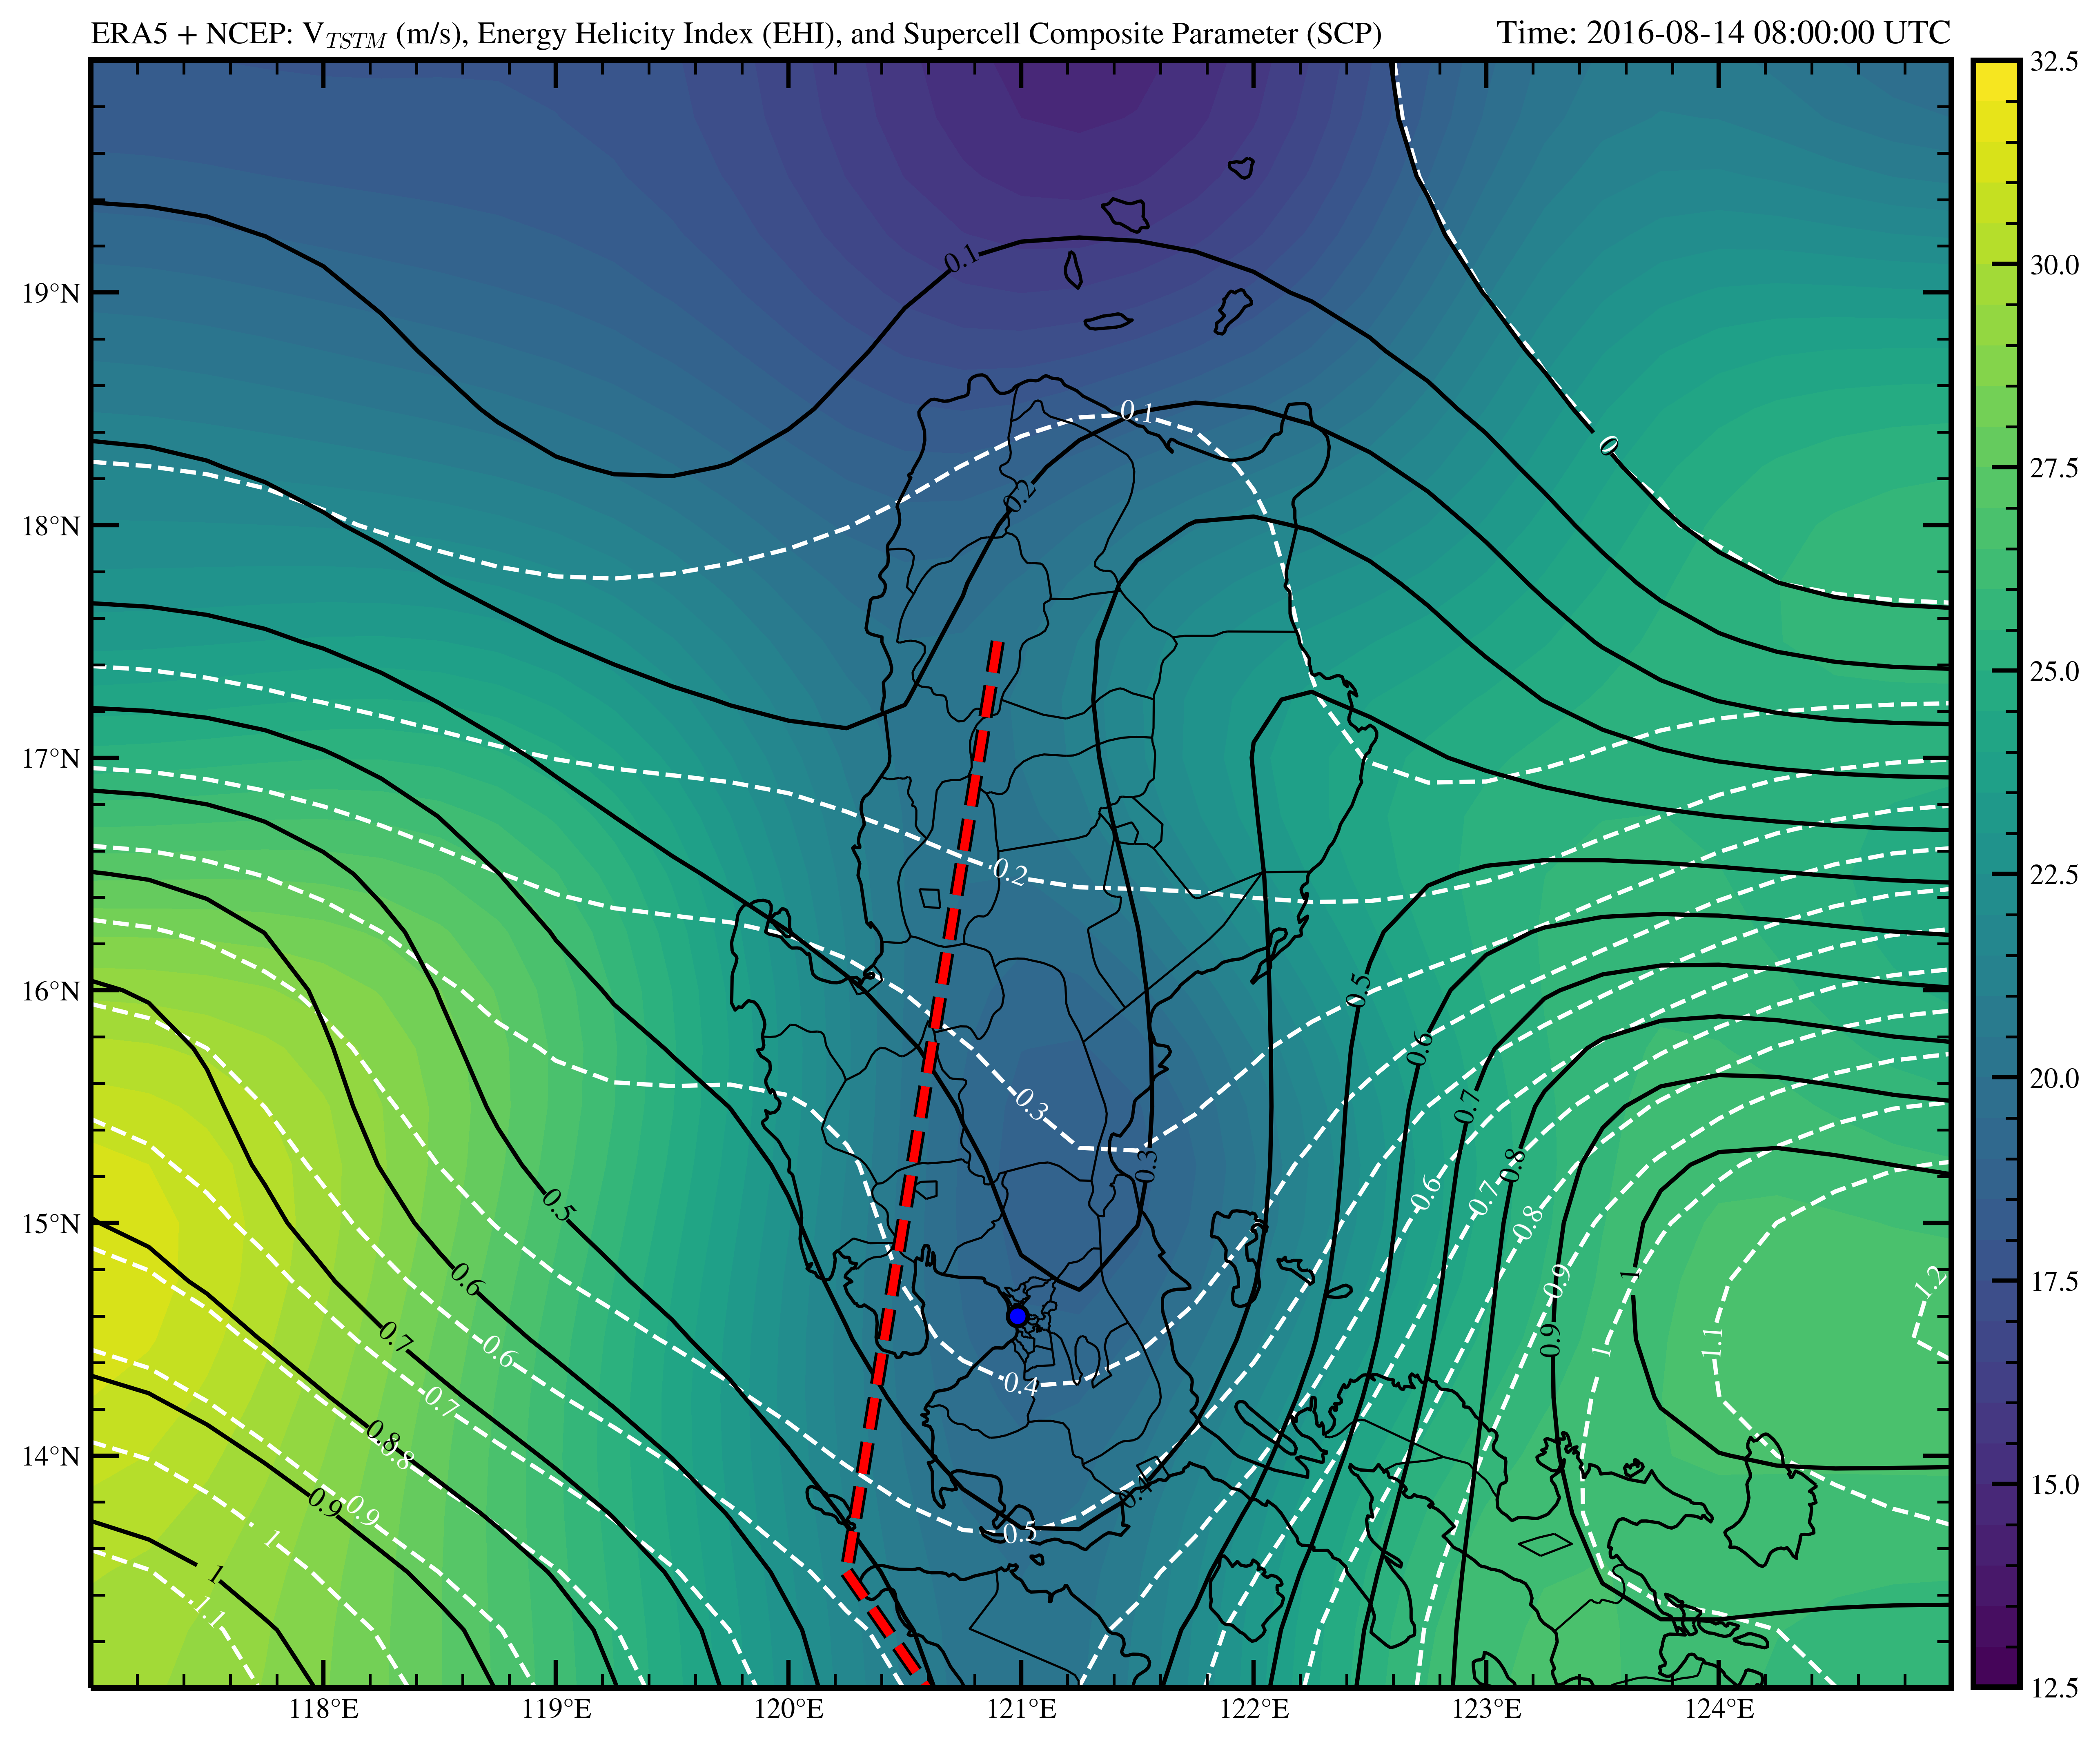

In [17]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([117, 125, 13, 20], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', 
                                                scale='10m', facecolor='none', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='k')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.LAND)

# Add EHI contours
ehi_range = np.arange(0, 2.1, 0.1)
ehf = ax.contour(lons, lats, ehi, ehi_range, colors='k', transform=datacrs)
ax.clabel(ehf, fmt='%3g')

# Add Updraft Velocity colorfill. Adjust colorbar tickmarks
wmax_range = np.arange(12.50, 33.00, 0.5)
upwm = ax.contourf(lons, lats, wmax, wmax_range, cmap='viridis', transform=datacrs)
cbar = plt.colorbar(upwm, orientation='vertical', pad=0.01, aspect=35, shrink=0.664, 
                    ticks=[12.50, 15.00, 17.50, 20.00, 22.50, 25.00, 27.50, 30.00, 32.50])
cbar.ax.set_yticklabels(['12.5' , '15.0', '17.5', '20.0', '22.5', '25.0', '27.5', '30.0', 
                         '32.5'])
cbar.ax.minorticks_on()
cbar.ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
cbar.ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Add SCP contour lines
scp_range = np.arange(0, 1.5, 0.1)
prs = ax.contour(lons, lats, scp, scp_range, colors='white',
                 transform=datacrs, zorder=1, linestyles='--')
ax.clabel(prs, fmt='%3g')

# Create a line(s) that highlights the surface trough
outline=pe.withStroke(linewidth=5, foreground='k')

point1 = dict(lon=120.90, lat=17.50)
point2 = dict(lon=120.25, lat=13.50)
lon_p = [point1['lon'], point2['lon']]
lat_p = [point1['lat'], point2['lat']]
ax.plot(lon_p, lat_p, color='red', lw=3, ls='--',
        path_effects=[outline, pe.Normal()], transform=ccrs.Geodetic())

point3 = dict(lon=120.25, lat=13.50)
point4 = dict(lon=122.40, lat=10.40)
lon_p1 = [point3['lon'], point4['lon']]
lat_p1 = [point3['lat'], point4['lat']]
ax.plot(lon_p1, lat_p1, color='red', lw=3, ls='--', 
        path_effects=[outline, pe.Normal()], transform=ccrs.Geodetic())

# Make some nice titles for the plot (one right, one left)
ax.set_title('ERA5 + NCEP: V$_{TSTM}$ (m/s), Energy Helicity Index (EHI), and Supercell Composite Parameter (SCP)', 
             loc='left', fontsize=11)
ax.set_title('Time: {} UTC'.format(vtime), loc='right')

# Add marker of Manila, NCR via its lats and lons
manila_lon, manila_lat = 120.9842, 14.5995
ax.plot(manila_lon, manila_lat, color='blue', markersize=7, 
        markeredgewidth=1.5, markeredgecolor='k', marker='o', transform=datacrs)

# Set X and Y-ticks for Latitude and Longitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.set_xticks(ax.get_xticks()[1:8]) #Hide end points of longitude tickmarks
ax.set_yticks(ax.get_yticks()[1:7]) #Hide end points of latitude tickmarks
ax.minorticks_on() 
ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.savefig('Updraft, EHI, SCP.jpg', bbox_inches="tight")
plt.show()